In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 16, 100, 100))

In [12]:
image = 1-image/100

In [13]:
image.shape

(133, 16, 100, 100)

In [14]:
image[0,0,:,:]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

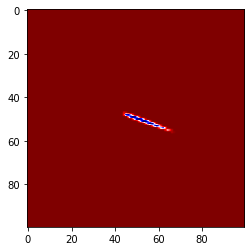

In [15]:
aaa=plt.imshow(image[0,15,:,:].T, cmap='seismic')
aaa.colorbar

In [16]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [17]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [18]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [19]:
y = y.reshape((133, 16, 2, 1))

In [20]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [21]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [22]:
geometry.shape

(2128, 1)

In [23]:
geometry = geometry.reshape((133, 16, 1))

In [24]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [25]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [26]:
x_train.shape

(2016, 100, 100, 1)

In [27]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 25)      650       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 25)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62500)             0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               12500200  
                                                                 
 secondHiddenLayer (Dense)   (None, 100)               20100     
                                                             

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
63/63 [==============================] - 16s 8ms/step - loss: 0.4673 - rmse: 0.6836
Epoch 2/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0154 - rmse: 0.1240
Epoch 3/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0128 - rmse: 0.1132
Epoch 4/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0113 - rmse: 0.1061
Epoch 5/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0993
Epoch 6/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0087 - rmse: 0.0931
Epoch 7/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0087 - rmse: 0.0934
Epoch 8/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0080 - rmse: 0.0894
Epoch 9/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0083 - rmse: 0.0914
Epoch 10/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0076 - rmse: 0.0871
Epoch 11/5000
63/63 [=================

63/63 [==============================] - 0s 5ms/step - loss: 0.0048 - rmse: 0.0692
Epoch 86/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0043 - rmse: 0.0653
Epoch 87/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0046 - rmse: 0.0681
Epoch 88/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0043 - rmse: 0.0659
Epoch 89/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0043 - rmse: 0.0655
Epoch 90/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0044 - rmse: 0.0662
Epoch 91/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0042 - rmse: 0.0647
Epoch 92/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0048 - rmse: 0.0691
Epoch 93/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0044 - rmse: 0.0665
Epoch 94/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0043 - rmse: 0.0652
Epoch 95/5000
63/63 [=======================

63/63 [==============================] - 0s 5ms/step - loss: 0.0032 - rmse: 0.0568
Epoch 169/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0553
Epoch 170/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0561
Epoch 171/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0548
Epoch 172/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0540
Epoch 173/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0545
Epoch 174/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0549
Epoch 175/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0543
Epoch 176/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0531
Epoch 177/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0543
Epoch 178/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0440
Epoch 252/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0447
Epoch 253/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0452
Epoch 254/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0443
Epoch 255/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0437
Epoch 256/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0435
Epoch 257/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0407
Epoch 258/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0416
Epoch 259/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0452
Epoch 260/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0427
Epoch 261/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0340
Epoch 335/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0331
Epoch 336/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0375
Epoch 337/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0343
Epoch 338/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0369
Epoch 339/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 340/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0342
Epoch 341/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0354
Epoch 342/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0335
Epoch 343/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0325
Epoch 344/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 7.4432e-04 - rmse: 0.0273
Epoch 416/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.2456e-04 - rmse: 0.0269
Epoch 417/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.6279e-04 - rmse: 0.0276
Epoch 418/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7242e-04 - rmse: 0.0278
Epoch 419/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4162e-04 - rmse: 0.0307
Epoch 420/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0338
Epoch 421/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.0875e-04 - rmse: 0.0301
Epoch 422/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.0746e-04 - rmse: 0.0284
Epoch 423/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.3262e-04 - rmse: 0.0270
Epoch 424/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.4011e-04 - rmse: 0.0272

63/63 [==============================] - 0s 5ms/step - loss: 5.4501e-04 - rmse: 0.0233
Epoch 496/5000
63/63 [==============================] - 0s 6ms/step - loss: 6.5369e-04 - rmse: 0.0255
Epoch 497/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.5129e-04 - rmse: 0.0255
Epoch 498/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.5654e-04 - rmse: 0.0275
Epoch 499/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9515e-04 - rmse: 0.0282
Epoch 500/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4587e-04 - rmse: 0.0233
Epoch 501/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.5817e-04 - rmse: 0.0236
Epoch 502/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.2056e-04 - rmse: 0.0228
Epoch 503/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.6727e-04 - rmse: 0.0238
Epoch 504/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.6073e-04 - rmse: 0.

63/63 [==============================] - 0s 6ms/step - loss: 5.2963e-04 - rmse: 0.0230
Epoch 576/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8220e-04 - rmse: 0.0241
Epoch 577/5000
63/63 [==============================] - 0s 6ms/step - loss: 6.0520e-04 - rmse: 0.0246
Epoch 578/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8644e-04 - rmse: 0.0242
Epoch 579/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8889e-04 - rmse: 0.0242
Epoch 580/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.3188e-04 - rmse: 0.0230
Epoch 581/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5047e-04 - rmse: 0.0212
Epoch 582/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6734e-04 - rmse: 0.0216
Epoch 583/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6207e-04 - rmse: 0.0215
Epoch 584/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7212e-04 - rmse: 0.

63/63 [==============================] - 0s 5ms/step - loss: 8.7553e-04 - rmse: 0.0296
Epoch 656/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.6304e-04 - rmse: 0.0257
Epoch 657/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.6752e-04 - rmse: 0.0238
Epoch 658/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.0936e-04 - rmse: 0.0225
Epoch 659/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.0495e-04 - rmse: 0.0224
Epoch 660/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1732e-04 - rmse: 0.0204
Epoch 661/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7046e-04 - rmse: 0.0217
Epoch 662/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.3832e-04 - rmse: 0.0232
Epoch 663/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6047e-04 - rmse: 0.0214
Epoch 664/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5151e-04 - rmse: 0.

63/63 [==============================] - 0s 5ms/step - loss: 4.7825e-04 - rmse: 0.0218
Epoch 736/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6634e-04 - rmse: 0.0216
Epoch 737/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3237e-04 - rmse: 0.0208
Epoch 738/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6484e-04 - rmse: 0.0215
Epoch 739/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2864e-04 - rmse: 0.0207
Epoch 740/5000
63/63 [==============================] - 0s 6ms/step - loss: 4.3796e-04 - rmse: 0.0209
Epoch 741/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.4152e-04 - rmse: 0.0210
Epoch 742/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1587e-04 - rmse: 0.0204
Epoch 743/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3634e-04 - rmse: 0.0208
Epoch 744/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5166e-04 - rmse: 0.

63/63 [==============================] - 0s 5ms/step - loss: 4.3991e-04 - rmse: 0.0209
Epoch 816/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7609e-04 - rmse: 0.0193
Epoch 817/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2999e-04 - rmse: 0.0207
Epoch 818/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7714e-04 - rmse: 0.0218
Epoch 819/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7596e-04 - rmse: 0.0218
Epoch 820/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9614e-04 - rmse: 0.0222
Epoch 821/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0686e-04 - rmse: 0.0201
Epoch 822/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1963e-04 - rmse: 0.0204
Epoch 823/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3703e-04 - rmse: 0.0209
Epoch 824/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5750e-04 - rmse: 0.

63/63 [==============================] - 0s 5ms/step - loss: 3.7152e-04 - rmse: 0.0192
Epoch 896/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7222e-04 - rmse: 0.0192
Epoch 897/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4379e-04 - rmse: 0.0185
Epoch 898/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2902e-04 - rmse: 0.0181
Epoch 899/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1005e-04 - rmse: 0.0202
Epoch 900/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5820e-04 - rmse: 0.0189
Epoch 901/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3861e-04 - rmse: 0.0184
Epoch 902/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5176e-04 - rmse: 0.0187
Epoch 903/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3854e-04 - rmse: 0.0184
Epoch 904/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4020e-04 - rmse: 0.

63/63 [==============================] - 0s 5ms/step - loss: 3.2512e-04 - rmse: 0.0180
Epoch 976/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9629e-04 - rmse: 0.0199
Epoch 977/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8590e-04 - rmse: 0.0220
Epoch 978/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1397e-04 - rmse: 0.0203
Epoch 979/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6987e-04 - rmse: 0.0192
Epoch 980/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0925e-04 - rmse: 0.0175
Epoch 981/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6548e-04 - rmse: 0.0191
Epoch 982/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9200e-04 - rmse: 0.0198
Epoch 983/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0960e-04 - rmse: 0.0175
Epoch 984/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3140e-04 - rmse: 0.

63/63 [==============================] - 0s 5ms/step - loss: 3.2476e-04 - rmse: 0.0180
Epoch 1055/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2134e-04 - rmse: 0.0179
Epoch 1056/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1389e-04 - rmse: 0.0177
Epoch 1057/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1091e-04 - rmse: 0.0176
Epoch 1058/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6538e-04 - rmse: 0.0191
Epoch 1059/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1433e-04 - rmse: 0.0177
Epoch 1060/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0922e-04 - rmse: 0.0175
Epoch 1061/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3053e-04 - rmse: 0.0181
Epoch 1062/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6173e-04 - rmse: 0.0190
Epoch 1063/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0583e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.5363e-04 - rmse: 0.0188
Epoch 1134/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3938e-04 - rmse: 0.0184
Epoch 1135/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8184e-04 - rmse: 0.0167
Epoch 1136/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3281e-04 - rmse: 0.0182
Epoch 1137/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2148e-04 - rmse: 0.0179
Epoch 1138/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.0327e-04 - rmse: 0.0174
Epoch 1139/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.2503e-04 - rmse: 0.0180
Epoch 1140/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4480e-04 - rmse: 0.0185
Epoch 1141/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.7287e-04 - rmse: 0.0193
Epoch 1142/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.4406e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 2.8222e-04 - rmse: 0.0167
Epoch 1213/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.0056e-04 - rmse: 0.0173
Epoch 1214/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.0216e-04 - rmse: 0.0173
Epoch 1215/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.6599e-04 - rmse: 0.0191
Epoch 1216/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.6675e-04 - rmse: 0.0191
Epoch 1217/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.7217e-04 - rmse: 0.0164
Epoch 1218/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.8380e-04 - rmse: 0.0168
Epoch 1219/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.4560e-04 - rmse: 0.0156
Epoch 1220/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.7889e-04 - rmse: 0.0166
Epoch 1221/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.5222e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.8389e-04 - rmse: 0.0168
Epoch 1292/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2236e-04 - rmse: 0.0179
Epoch 1293/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9615e-04 - rmse: 0.0171
Epoch 1294/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4659e-04 - rmse: 0.0156
Epoch 1295/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.4320e-04 - rmse: 0.0155
Epoch 1296/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.6467e-04 - rmse: 0.0162
Epoch 1297/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.5172e-04 - rmse: 0.0158
Epoch 1298/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1147e-04 - rmse: 0.0176
Epoch 1299/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9982e-04 - rmse: 0.0173
Epoch 1300/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8960e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 3.8517e-04 - rmse: 0.0196
Epoch 1371/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3494e-04 - rmse: 0.0182
Epoch 1372/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1074e-04 - rmse: 0.0176
Epoch 1373/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5959e-04 - rmse: 0.0160
Epoch 1374/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6367e-04 - rmse: 0.0162
Epoch 1375/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7305e-04 - rmse: 0.0165
Epoch 1376/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0872e-04 - rmse: 0.0144
Epoch 1377/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0047e-04 - rmse: 0.0141
Epoch 1378/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.1051e-04 - rmse: 0.0144
Epoch 1379/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2549e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 2.3049e-04 - rmse: 0.0151
Epoch 1450/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.1318e-04 - rmse: 0.0145
Epoch 1451/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.2758e-04 - rmse: 0.0150
Epoch 1452/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.1012e-04 - rmse: 0.0144
Epoch 1453/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2688e-04 - rmse: 0.0150
Epoch 1454/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2959e-04 - rmse: 0.0151
Epoch 1455/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1322e-04 - rmse: 0.0176
Epoch 1456/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4562e-04 - rmse: 0.0156
Epoch 1457/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5661e-04 - rmse: 0.0159
Epoch 1458/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7140e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.8392e-04 - rmse: 0.0135
Epoch 1529/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3905e-04 - rmse: 0.0154
Epoch 1530/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8867e-04 - rmse: 0.0169
Epoch 1531/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3420e-04 - rmse: 0.0152
Epoch 1532/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9806e-04 - rmse: 0.0140
Epoch 1533/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2956e-04 - rmse: 0.0151
Epoch 1534/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0266e-04 - rmse: 0.0142
Epoch 1535/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0006e-04 - rmse: 0.0141
Epoch 1536/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4034e-04 - rmse: 0.0154
Epoch 1537/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8387e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 3.1992e-04 - rmse: 0.0178
Epoch 1608/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4371e-04 - rmse: 0.0155
Epoch 1609/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2021e-04 - rmse: 0.0148
Epoch 1610/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8488e-04 - rmse: 0.0135
Epoch 1611/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7855e-04 - rmse: 0.0133
Epoch 1612/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.6928e-04 - rmse: 0.0129
Epoch 1613/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0094e-04 - rmse: 0.0141
Epoch 1614/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3557e-04 - rmse: 0.0153
Epoch 1615/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8435e-04 - rmse: 0.0195
Epoch 1616/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8279e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.5432e-04 - rmse: 0.0159
Epoch 1687/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0669e-04 - rmse: 0.0143
Epoch 1688/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3520e-04 - rmse: 0.0153
Epoch 1689/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4599e-04 - rmse: 0.0156
Epoch 1690/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4697e-04 - rmse: 0.0156
Epoch 1691/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9561e-04 - rmse: 0.0139
Epoch 1692/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8164e-04 - rmse: 0.0134
Epoch 1693/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.0077e-04 - rmse: 0.0141
Epoch 1694/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0095e-04 - rmse: 0.0141
Epoch 1695/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9572e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.5526e-04 - rmse: 0.0124
Epoch 1766/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6860e-04 - rmse: 0.0129
Epoch 1767/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2124e-04 - rmse: 0.0179
Epoch 1768/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3759e-04 - rmse: 0.0183
Epoch 1769/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4058e-04 - rmse: 0.0154
Epoch 1770/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.1014e-04 - rmse: 0.0144
Epoch 1771/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7448e-04 - rmse: 0.0131
Epoch 1772/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0569e-04 - rmse: 0.0143
Epoch 1773/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4156e-04 - rmse: 0.0155
Epoch 1774/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.1797e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.3291e-04 - rmse: 0.0114
Epoch 1845/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7189e-04 - rmse: 0.0130
Epoch 1846/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6342e-04 - rmse: 0.0127
Epoch 1847/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.5057e-04 - rmse: 0.0122
Epoch 1848/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4253e-04 - rmse: 0.0118
Epoch 1849/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6688e-04 - rmse: 0.0128
Epoch 1850/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5671e-04 - rmse: 0.0124
Epoch 1851/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5660e-04 - rmse: 0.0124
Epoch 1852/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5783e-04 - rmse: 0.0125
Epoch 1853/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2573e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.1616e-04 - rmse: 0.0107
Epoch 1924/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1114e-04 - rmse: 0.0104
Epoch 1925/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1094e-04 - rmse: 0.0104
Epoch 1926/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2792e-04 - rmse: 0.0112
Epoch 1927/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0332e-04 - rmse: 0.0142
Epoch 1928/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.1885e-04 - rmse: 0.0147
Epoch 1929/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6065e-04 - rmse: 0.0214
Epoch 1930/5000
63/63 [==============================] - 0s 6ms/step - loss: 4.1796e-04 - rmse: 0.0204
Epoch 1931/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.1058e-04 - rmse: 0.0175
Epoch 1932/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.1474e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.2831e-04 - rmse: 0.0150
Epoch 2003/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0747e-04 - rmse: 0.0143
Epoch 2004/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4181e-04 - rmse: 0.0118
Epoch 2005/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3441e-04 - rmse: 0.0115
Epoch 2006/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1052e-04 - rmse: 0.0104
Epoch 2007/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1075e-04 - rmse: 0.0104
Epoch 2008/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0376e-04 - rmse: 0.0101
Epoch 2009/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0986e-04 - rmse: 0.0104
Epoch 2010/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2236e-04 - rmse: 0.0109
Epoch 2011/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1696e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.8926e-04 - rmse: 0.0137
Epoch 2082/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3739e-04 - rmse: 0.0116
Epoch 2083/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4458e-04 - rmse: 0.0119
Epoch 2084/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2603e-04 - rmse: 0.0111
Epoch 2085/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1402e-04 - rmse: 0.0105
Epoch 2086/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2924e-04 - rmse: 0.0112
Epoch 2087/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2825e-04 - rmse: 0.0112
Epoch 2088/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5496e-04 - rmse: 0.0123
Epoch 2089/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5512e-04 - rmse: 0.0123
Epoch 2090/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.1578e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.6776e-04 - rmse: 0.0128
Epoch 2161/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.0554e-04 - rmse: 0.0224
Epoch 2162/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0396
Epoch 2163/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0347
Epoch 2164/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.6415e-04 - rmse: 0.0237
Epoch 2165/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9434e-04 - rmse: 0.0171
Epoch 2166/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5292e-04 - rmse: 0.0123
Epoch 2167/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3128e-04 - rmse: 0.0113
Epoch 2168/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1708e-04 - rmse: 0.0107
Epoch 2169/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0188e-04 - rmse: 0

63/63 [==============================] - 0s 5ms/step - loss: 1.3357e-04 - rmse: 0.0114
Epoch 2240/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2680e-04 - rmse: 0.0111
Epoch 2241/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2880e-04 - rmse: 0.0112
Epoch 2242/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1630e-04 - rmse: 0.0106
Epoch 2243/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4106e-04 - rmse: 0.0118
Epoch 2244/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2338e-04 - rmse: 0.0110
Epoch 2245/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1567e-04 - rmse: 0.0106
Epoch 2246/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1997e-04 - rmse: 0.0108
Epoch 2247/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1837e-04 - rmse: 0.0107
Epoch 2248/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4214e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.1423e-04 - rmse: 0.0145
Epoch 2319/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6167e-04 - rmse: 0.0126
Epoch 2320/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2070e-04 - rmse: 0.0109
Epoch 2321/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1138e-04 - rmse: 0.0104
Epoch 2322/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.7306e-05 - rmse: 0.0097
Epoch 2323/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.7547e-05 - rmse: 0.0097
Epoch 2324/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2491e-04 - rmse: 0.0110
Epoch 2325/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1299e-04 - rmse: 0.0105
Epoch 2326/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1177e-04 - rmse: 0.0104
Epoch 2327/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2113e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.0320e-04 - rmse: 0.0100
Epoch 2398/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1004e-04 - rmse: 0.0103
Epoch 2399/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1160e-04 - rmse: 0.0104
Epoch 2400/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2890e-04 - rmse: 0.0112
Epoch 2401/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2974e-04 - rmse: 0.0113
Epoch 2402/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1654e-04 - rmse: 0.0107
Epoch 2403/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2029e-04 - rmse: 0.0108
Epoch 2404/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2206e-04 - rmse: 0.0109
Epoch 2405/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0109e-04 - rmse: 0.0099
Epoch 2406/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0987e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.6985e-04 - rmse: 0.0129
Epoch 2477/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.4839e-04 - rmse: 0.0121
Epoch 2478/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3638e-04 - rmse: 0.0115
Epoch 2479/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3228e-04 - rmse: 0.0114
Epoch 2480/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2569e-04 - rmse: 0.0111
Epoch 2481/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1147e-04 - rmse: 0.0104
Epoch 2482/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4836e-05 - rmse: 0.0096
Epoch 2483/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0748e-04 - rmse: 0.0102
Epoch 2484/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1302e-04 - rmse: 0.0105
Epoch 2485/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1884e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.3266e-04 - rmse: 0.0114
Epoch 2556/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.7134e-04 - rmse: 0.0130
Epoch 2557/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7769e-04 - rmse: 0.0132
Epoch 2558/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1684e-04 - rmse: 0.0107
Epoch 2559/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3501e-04 - rmse: 0.0115
Epoch 2560/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5908e-04 - rmse: 0.0125
Epoch 2561/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2501e-04 - rmse: 0.0110
Epoch 2562/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3257e-04 - rmse: 0.0114
Epoch 2563/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3315e-04 - rmse: 0.0114
Epoch 2564/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3892e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.6119e-04 - rmse: 0.0126
Epoch 2635/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0229e-04 - rmse: 0.0141
Epoch 2636/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0138e-04 - rmse: 0.0173
Epoch 2637/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4881e-04 - rmse: 0.0157
Epoch 2638/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8954e-04 - rmse: 0.0137
Epoch 2639/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9506e-04 - rmse: 0.0139
Epoch 2640/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7016e-04 - rmse: 0.0129
Epoch 2641/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4590e-04 - rmse: 0.0119
Epoch 2642/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3738e-04 - rmse: 0.0116
Epoch 2643/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3037e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.2150e-04 - rmse: 0.0109
Epoch 2714/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1572e-04 - rmse: 0.0106
Epoch 2715/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0725e-04 - rmse: 0.0102
Epoch 2716/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1221e-04 - rmse: 0.0104
Epoch 2717/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1664e-04 - rmse: 0.0107
Epoch 2718/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4084e-04 - rmse: 0.0117
Epoch 2719/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3577e-04 - rmse: 0.0182
Epoch 2720/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.9369e-04 - rmse: 0.0298
Epoch 2721/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0369
Epoch 2722/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.2322e-04 - rms

63/63 [==============================] - 0s 5ms/step - loss: 8.7660e-05 - rmse: 0.0092
Epoch 2793/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.2553e-05 - rmse: 0.0095
Epoch 2794/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0358e-04 - rmse: 0.0100
Epoch 2795/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8314e-04 - rmse: 0.0134
Epoch 2796/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3432e-04 - rmse: 0.0152
Epoch 2797/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9628e-04 - rmse: 0.0139
Epoch 2798/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4411e-04 - rmse: 0.0119
Epoch 2799/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3421e-04 - rmse: 0.0114
Epoch 2800/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0567e-04 - rmse: 0.0101
Epoch 2801/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.6131e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 1.1102e-04 - rmse: 0.0104
Epoch 2872/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5821e-04 - rmse: 0.0124
Epoch 2873/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5651e-04 - rmse: 0.0124
Epoch 2874/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7178e-04 - rmse: 0.0130
Epoch 2875/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6299e-04 - rmse: 0.0161
Epoch 2876/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2078e-04 - rmse: 0.0204
Epoch 2877/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2837e-04 - rmse: 0.0180
Epoch 2878/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0598e-04 - rmse: 0.0142
Epoch 2879/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4693e-04 - rmse: 0.0120
Epoch 2880/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2047e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.1858e-04 - rmse: 0.0147
Epoch 2951/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8536e-04 - rmse: 0.0135
Epoch 2952/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6123e-04 - rmse: 0.0126
Epoch 2953/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5263e-04 - rmse: 0.0122
Epoch 2954/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7399e-04 - rmse: 0.0131
Epoch 2955/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0604e-04 - rmse: 0.0201
Epoch 2956/5000
63/63 [==============================] - 0s 6ms/step - loss: 4.8623e-04 - rmse: 0.0220
Epoch 2957/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.9163e-04 - rmse: 0.0243
Epoch 2958/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7903e-04 - rmse: 0.0166
Epoch 2959/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5461e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 9.0693e-05 - rmse: 0.0093
Epoch 3030/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.3430e-05 - rmse: 0.0095
Epoch 3031/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.7058e-05 - rmse: 0.0097
Epoch 3032/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0299e-04 - rmse: 0.0100
Epoch 3033/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.8384e-05 - rmse: 0.0098
Epoch 3034/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.1369e-05 - rmse: 0.0094
Epoch 3035/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0743e-04 - rmse: 0.0102
Epoch 3036/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.8884e-04 - rmse: 0.0136
Epoch 3037/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.5034e-04 - rmse: 0.0121
Epoch 3038/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.4603e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.3197e-04 - rmse: 0.0113
Epoch 3109/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1337e-04 - rmse: 0.0105
Epoch 3110/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0315e-04 - rmse: 0.0100
Epoch 3111/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0138e-04 - rmse: 0.0099
Epoch 3112/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.2005e-04 - rmse: 0.0108
Epoch 3113/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.9247e-05 - rmse: 0.0098
Epoch 3114/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.1242e-05 - rmse: 0.0094
Epoch 3115/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0070e-04 - rmse: 0.0099
Epoch 3116/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.3956e-05 - rmse: 0.0095
Epoch 3117/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.8927e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 1.0845e-04 - rmse: 0.0103
Epoch 3188/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1991e-04 - rmse: 0.0108
Epoch 3189/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9854e-04 - rmse: 0.0140
Epoch 3190/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3667e-04 - rmse: 0.0183
Epoch 3191/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1239e-04 - rmse: 0.0176
Epoch 3192/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8520e-04 - rmse: 0.0135
Epoch 3193/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8503e-04 - rmse: 0.0135
Epoch 3194/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1792e-04 - rmse: 0.0107
Epoch 3195/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2064e-04 - rmse: 0.0108
Epoch 3196/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0739e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.0264e-04 - rmse: 0.0100
Epoch 3267/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.9161e-05 - rmse: 0.0098
Epoch 3268/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.7751e-05 - rmse: 0.0092
Epoch 3269/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.4018e-05 - rmse: 0.0095
Epoch 3270/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0275e-04 - rmse: 0.0100
Epoch 3271/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.5858e-05 - rmse: 0.0091
Epoch 3272/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.8645e-05 - rmse: 0.0092
Epoch 3273/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0103e-04 - rmse: 0.0099
Epoch 3274/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0153e-04 - rmse: 0.0099
Epoch 3275/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0368e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.6149e-04 - rmse: 0.0126
Epoch 3346/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.6561e-04 - rmse: 0.0162
Epoch 3347/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.8753e-04 - rmse: 0.0136
Epoch 3348/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.1495e-04 - rmse: 0.0145
Epoch 3349/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1560e-04 - rmse: 0.0106
Epoch 3350/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.9589e-05 - rmse: 0.0093
Epoch 3351/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.2319e-05 - rmse: 0.0094
Epoch 3352/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.9192e-05 - rmse: 0.0093
Epoch 3353/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.3168e-05 - rmse: 0.0089
Epoch 3354/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.2127e-05 -

63/63 [==============================] - 0s 6ms/step - loss: 8.3475e-05 - rmse: 0.0089
Epoch 3425/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.3855e-05 - rmse: 0.0090
Epoch 3426/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.9120e-05 - rmse: 0.0093
Epoch 3427/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.3164e-05 - rmse: 0.0089
Epoch 3428/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.6512e-05 - rmse: 0.0091
Epoch 3429/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.2587e-05 - rmse: 0.0089
Epoch 3430/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.2470e-05 - rmse: 0.0089
Epoch 3431/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.8149e-05 - rmse: 0.0092
Epoch 3432/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.1000e-05 - rmse: 0.0094
Epoch 3433/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1178e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.0577e-04 - rmse: 0.0101
Epoch 3504/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.4780e-05 - rmse: 0.0096
Epoch 3505/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0600e-04 - rmse: 0.0101
Epoch 3506/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.9495e-05 - rmse: 0.0093
Epoch 3507/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.3026e-05 - rmse: 0.0095
Epoch 3508/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.4526e-05 - rmse: 0.0090
Epoch 3509/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.8827e-05 - rmse: 0.0092
Epoch 3510/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.7333e-05 - rmse: 0.0097
Epoch 3511/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.2879e-04 - rmse: 0.0112
Epoch 3512/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1918e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.4787e-04 - rmse: 0.0120
Epoch 3583/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.3496e-04 - rmse: 0.0115
Epoch 3584/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1350e-04 - rmse: 0.0105
Epoch 3585/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1790e-04 - rmse: 0.0107
Epoch 3586/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1048e-04 - rmse: 0.0103
Epoch 3587/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0512e-04 - rmse: 0.0101
Epoch 3588/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0441e-04 - rmse: 0.0100
Epoch 3589/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1696e-04 - rmse: 0.0106
Epoch 3590/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0114e-04 - rmse: 0.0099
Epoch 3591/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.2478e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 3.6415e-04 - rmse: 0.0190
Epoch 3662/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.2785e-04 - rmse: 0.0150
Epoch 3663/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.4901e-04 - rmse: 0.0121
Epoch 3664/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0625e-04 - rmse: 0.0101
Epoch 3665/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0971e-04 - rmse: 0.0103
Epoch 3666/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.8797e-05 - rmse: 0.0098
Epoch 3667/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.7538e-05 - rmse: 0.0092
Epoch 3668/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.7216e-05 - rmse: 0.0097
Epoch 3669/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.0849e-05 - rmse: 0.0093
Epoch 3670/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0212e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.0076e-04 - rmse: 0.0099
Epoch 3741/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.2214e-04 - rmse: 0.0109
Epoch 3742/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0761e-04 - rmse: 0.0102
Epoch 3743/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.7909e-05 - rmse: 0.0092
Epoch 3744/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.8314e-05 - rmse: 0.0092
Epoch 3745/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.7583e-05 - rmse: 0.0097
Epoch 3746/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1155e-04 - rmse: 0.0104
Epoch 3747/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.4193e-04 - rmse: 0.0118
Epoch 3748/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.2281e-04 - rmse: 0.0179
Epoch 3749/5000
63/63 [==============================] - 0s 6ms/step - loss: 4.4068e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 2.7595e-04 - rmse: 0.0165
Epoch 3820/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.8527e-04 - rmse: 0.0135
Epoch 3821/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2862e-04 - rmse: 0.0112
Epoch 3822/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1429e-04 - rmse: 0.0105
Epoch 3823/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.7585e-04 - rmse: 0.0131
Epoch 3824/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8485e-04 - rmse: 0.0168
Epoch 3825/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8325e-04 - rmse: 0.0167
Epoch 3826/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3912e-04 - rmse: 0.0153
Epoch 3827/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.7467e-04 - rmse: 0.0131
Epoch 3828/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1340e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.3031e-04 - rmse: 0.0151
Epoch 3899/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4715e-04 - rmse: 0.0120
Epoch 3900/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2860e-04 - rmse: 0.0112
Epoch 3901/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1999e-04 - rmse: 0.0108
Epoch 3902/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6292e-04 - rmse: 0.0126
Epoch 3903/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0287e-04 - rmse: 0.0100
Epoch 3904/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.8967e-05 - rmse: 0.0092
Epoch 3905/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.8077e-05 - rmse: 0.0092
Epoch 3906/5000
63/63 [==============================] - 0s 6ms/step - loss: 7.9009e-05 - rmse: 0.0087
Epoch 3907/5000
63/63 [==============================] - 0s 6ms/step - loss: 7.8103e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 7.9414e-05 - rmse: 0.0087
Epoch 3978/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.1262e-05 - rmse: 0.0088
Epoch 3979/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9646e-05 - rmse: 0.0087
Epoch 3980/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9338e-05 - rmse: 0.0087
Epoch 3981/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.7717e-05 - rmse: 0.0092
Epoch 3982/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.8231e-05 - rmse: 0.0086
Epoch 3983/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.2859e-05 - rmse: 0.0089
Epoch 3984/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.2109e-05 - rmse: 0.0089
Epoch 3985/5000
63/63 [==============================] - 0s 6ms/step - loss: 7.9093e-05 - rmse: 0.0087
Epoch 3986/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.7081e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 7.9033e-05 - rmse: 0.0087
Epoch 4057/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7225e-05 - rmse: 0.0086
Epoch 4058/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.8819e-05 - rmse: 0.0087
Epoch 4059/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7246e-05 - rmse: 0.0086
Epoch 4060/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.2727e-05 - rmse: 0.0089
Epoch 4061/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.4504e-05 - rmse: 0.0084
Epoch 4062/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7673e-05 - rmse: 0.0086
Epoch 4063/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.2635e-05 - rmse: 0.0089
Epoch 4064/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.0771e-05 - rmse: 0.0088
Epoch 4065/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7686e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 9.2377e-05 - rmse: 0.0094
Epoch 4136/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.6904e-05 - rmse: 0.0097
Epoch 4137/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.7664e-05 - rmse: 0.0092
Epoch 4138/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.5848e-05 - rmse: 0.0096
Epoch 4139/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.4502e-05 - rmse: 0.0095
Epoch 4140/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.7920e-05 - rmse: 0.0097
Epoch 4141/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.6269e-05 - rmse: 0.0096
Epoch 4142/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0980e-04 - rmse: 0.0103
Epoch 4143/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0525e-04 - rmse: 0.0101
Epoch 4144/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0763e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.5625e-04 - rmse: 0.0123
Epoch 4215/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3531e-04 - rmse: 0.0152
Epoch 4216/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.5476e-04 - rmse: 0.0255
Epoch 4217/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9976e-04 - rmse: 0.0223
Epoch 4218/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9666e-04 - rmse: 0.0171
Epoch 4219/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5982e-04 - rmse: 0.0125
Epoch 4220/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.9020e-05 - rmse: 0.0098
Epoch 4221/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0251e-04 - rmse: 0.0099
Epoch 4222/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0729e-04 - rmse: 0.0102
Epoch 4223/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.1724e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 9.6483e-05 - rmse: 0.0096
Epoch 4294/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.9913e-05 - rmse: 0.0093
Epoch 4295/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.7227e-05 - rmse: 0.0097
Epoch 4296/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0815e-04 - rmse: 0.0102
Epoch 4297/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.3840e-04 - rmse: 0.0116
Epoch 4298/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1902e-04 - rmse: 0.0107
Epoch 4299/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0681e-04 - rmse: 0.0101
Epoch 4300/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0697e-04 - rmse: 0.0102
Epoch 4301/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.6447e-05 - rmse: 0.0091
Epoch 4302/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0183e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.1680e-04 - rmse: 0.0106
Epoch 4373/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0599e-04 - rmse: 0.0101
Epoch 4374/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.6587e-05 - rmse: 0.0096
Epoch 4375/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.9937e-05 - rmse: 0.0093
Epoch 4376/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.2352e-05 - rmse: 0.0094
Epoch 4377/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.7592e-05 - rmse: 0.0097
Epoch 4378/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.0124e-04 - rmse: 0.0099
Epoch 4379/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0787e-04 - rmse: 0.0102
Epoch 4380/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2791e-04 - rmse: 0.0111
Epoch 4381/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1748e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 8.2231e-05 - rmse: 0.0089
Epoch 4452/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.8741e-05 - rmse: 0.0087
Epoch 4453/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.0758e-05 - rmse: 0.0088
Epoch 4454/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9019e-05 - rmse: 0.0087
Epoch 4455/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.2551e-05 - rmse: 0.0089
Epoch 4456/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.0763e-05 - rmse: 0.0093
Epoch 4457/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.7519e-05 - rmse: 0.0091
Epoch 4458/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.8313e-05 - rmse: 0.0097
Epoch 4459/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0668e-04 - rmse: 0.0101
Epoch 4460/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4967e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 1.4822e-04 - rmse: 0.0120
Epoch 4531/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2889e-04 - rmse: 0.0112
Epoch 4532/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1476e-04 - rmse: 0.0105
Epoch 4533/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1381e-04 - rmse: 0.0105
Epoch 4534/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2269e-04 - rmse: 0.0148
Epoch 4535/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2754e-04 - rmse: 0.0206
Epoch 4536/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5757e-04 - rmse: 0.0188
Epoch 4537/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3784e-04 - rmse: 0.0153
Epoch 4538/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9659e-04 - rmse: 0.0139
Epoch 4539/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2618e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 9.1296e-05 - rmse: 0.0093
Epoch 4610/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.1855e-05 - rmse: 0.0094
Epoch 4611/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4762e-05 - rmse: 0.0095
Epoch 4612/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1297e-04 - rmse: 0.0104
Epoch 4613/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.2451e-04 - rmse: 0.0110
Epoch 4614/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4500e-04 - rmse: 0.0119
Epoch 4615/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.3332e-04 - rmse: 0.0114
Epoch 4616/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5994e-04 - rmse: 0.0125
Epoch 4617/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5342e-04 - rmse: 0.0122
Epoch 4618/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.4458e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 8.1599e-05 - rmse: 0.0088
Epoch 4689/5000
63/63 [==============================] - 0s 6ms/step - loss: 7.5087e-05 - rmse: 0.0084
Epoch 4690/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.1123e-05 - rmse: 0.0088
Epoch 4691/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.8267e-05 - rmse: 0.0086
Epoch 4692/5000
63/63 [==============================] - 0s 6ms/step - loss: 7.6291e-05 - rmse: 0.0085
Epoch 4693/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.2219e-05 - rmse: 0.0088
Epoch 4694/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.5518e-05 - rmse: 0.0085
Epoch 4695/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.2873e-05 - rmse: 0.0083
Epoch 4696/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.1252e-05 - rmse: 0.0088
Epoch 4697/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.0421e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 8.8672e-05 - rmse: 0.0092
Epoch 4768/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4898e-05 - rmse: 0.0095
Epoch 4769/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.1058e-05 - rmse: 0.0093
Epoch 4770/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.5774e-05 - rmse: 0.0090
Epoch 4771/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.0840e-05 - rmse: 0.0093
Epoch 4772/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4619e-05 - rmse: 0.0095
Epoch 4773/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.7247e-05 - rmse: 0.0097
Epoch 4774/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0285e-04 - rmse: 0.0099
Epoch 4775/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1253e-04 - rmse: 0.0104
Epoch 4776/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0562e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.1793e-04 - rmse: 0.0107
Epoch 4847/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0143e-04 - rmse: 0.0099
Epoch 4848/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.3496e-05 - rmse: 0.0089
Epoch 4849/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.3061e-05 - rmse: 0.0089
Epoch 4850/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9606e-05 - rmse: 0.0087
Epoch 4851/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9910e-05 - rmse: 0.0087
Epoch 4852/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7304e-05 - rmse: 0.0086
Epoch 4853/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.6245e-05 - rmse: 0.0085
Epoch 4854/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.6374e-05 - rmse: 0.0091
Epoch 4855/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.4988e-05 -

63/63 [==============================] - 0s 5ms/step - loss: 1.2083e-04 - rmse: 0.0108
Epoch 4926/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0507e-04 - rmse: 0.0101
Epoch 4927/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1453e-04 - rmse: 0.0105
Epoch 4928/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1354e-04 - rmse: 0.0105
Epoch 4929/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.1210e-04 - rmse: 0.0104
Epoch 4930/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.3087e-04 - rmse: 0.0113
Epoch 4931/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1335e-04 - rmse: 0.0105
Epoch 4932/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.1308e-04 - rmse: 0.0104
Epoch 4933/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0533e-04 - rmse: 0.0101
Epoch 4934/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.0784e-04 -

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:29:10.808108


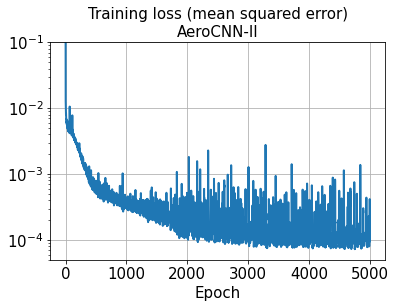

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

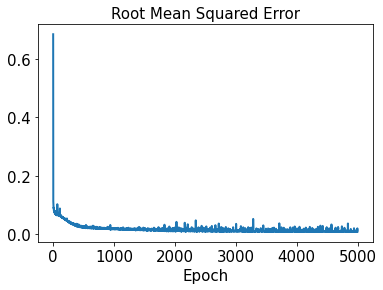

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

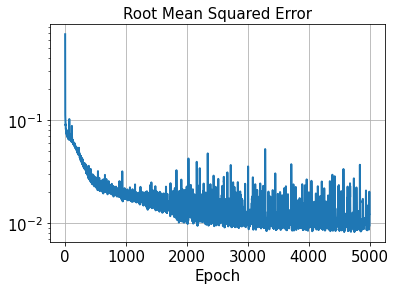

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [35]:
test_results = model.evaluate(x_train)

63/63 [==============================] - 0s 1ms/step - loss: 4.0373e-06 - rmse: 0.0000e+00


In [36]:
decoded_train = model.predict(x_train)

63/63 [==============================] - 0s 1ms/step


In [37]:
x_train.shape

(2016, 100, 100, 1)

In [38]:
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 4ms/step


In [39]:
error_train_abs = np.abs(decoded_train - y_train)

In [40]:
error_test_abs = np.abs(decoded_test - y_test)

In [41]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [42]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [43]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [44]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [45]:
decoded_train.shape

(2016, 2, 1)

In [46]:
os.chdir("D:\\TrainedModels\\20221005")
model.save('AeroCNN-II_25kernel_2by2MaxPooling_1CNNlayer_testSize0.05.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.017214486009390566


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.14986219779737342


In [49]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.016563118764614686


In [50]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.029560144033881755


In [51]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.14823422973791503


In [52]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.18795625385764664


In [53]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.04294350617977795, 0.04010298705683987, 0.021137350402450992, 0.010465197323894003, 0.015612902767512456, 0.23417769610472494, 0.010859922205412532, 0.009870532726794452, 0.006471788102307242, 0.006109245476262282, 0.006836598602887792, 0.009958948575136314, 0.004495815930535459, 0.03236033760776212, 0.020361627477454777, 0.016963675257716998, 0.011844019302284417, 0.01296200765196489, 0.007008480190896706, 0.008874088669431167, 0.06462565181587664, 0.06926122423537107, 0.012557690764889126, 0.013427599542450106, 0.006353277902380895, 0.006310480135566186, 0.09776446066674332, 0.004940415826309495, 0.012856721738382763, 0.15160836603941588, 0.07305164139328121, 0.07743524046566232, 0.04001206123696845, 0.020991953236650995, 0.017826916572307897, 0.012247800902990224, 0.030620538212412785, 0.049887333867200734, 0.002807530185702001, 0.0036652819046687373, 0.004753650504925134, 0.0017409941448004885, 0.004847399471589263, 0.007574925492354748, 0.027322002696006542, 0.02533022507472222

In [54]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.028169394467735406, 0.07890716163479461, 0.04115599340882929, 0.041948599764954506, 0.08629911749981552, 0.163752998702359, 0.0684409729755996, 0.11640083276321736, 0.08589018793697424, 0.04006979670421344, 0.40939718459679303, 0.07701311766325587, 0.10485943581855484, 0.14506538908568564, 0.1076422001235391, 0.10844081315393789, 0.027967472643583995, 0.09848794107751299, 0.05134017928871361, 0.12007517716931912, 1.1670088768844578, 0.10871378437554882, 0.006631749592437441, 0.02897850668826885, 0.03487298625662322, 0.003213071010132761, 0.005597493392272051, 0.03594468073416702, 0.02771108921906241, 0.040854550846945954, 0.20947144977159823, 0.4070354971640605, 0.019759185491653446, 0.024555645949647435, 0.00950614992312412, 0.0931496902623481, 0.3500517964906086, 1.4037720838956471, 0.3618494000674808, 0.24848367207069366, 0.14121161869747717, 0.15269263148149184, 0.5522309522684751, 0.01634879808173975, 0.025622011208662067, 0.2617807058361346, 0.08998028901599212, 0.082450980816

In [55]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.04264468808132126, 0.03926277054299976, 0.018336640495877916, 0.008887576578949445, 0.012234988306003357, 0.23732666649578843, 0.00933397883606742, 0.008790285722488508, 0.006243603309472453, 0.004280892062546936, 0.005975698992120613, 0.01009839321112505, 0.003706836693811054, 0.03393111477027013, 0.02020738848312528, 0.017483831141115822, 0.0033078960238440173, 0.010729737125534747, 0.004992917706075989, 0.008878301872732008, 0.06474836352447509, 0.06326168853008296, 0.010473999338508523, 0.013329282933927596, 0.006324781291576519, 0.005446886748554016, 0.09878932774432105, 0.0019636460242191465, 0.010860551545053674, 0.15640855649152496, 0.07703563388804796, 0.08230197396233459, 0.03836848036887201, 0.020277170025492484, 0.017756839098713912, 1.3370094165496258e-05, 0.03147963136775378, 0.04981850207479101, 0.0008120992379160783, 0.003285607086979873, 0.004221332795090291, 0.0017414061028725642, 0.004579096659205703, 0.00745482434197099, 0.027634568937162787, 0.025094848116617146

In [56]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.04817868679222398, 0.062012139034919284, 0.13580624914935938, 0.1242581482313609, 0.11533852088368467, 0.16862954531383118, 0.1098158163854274, 0.13966441601673255, 0.06145988877311336, 0.09951000309813536, 0.031591816262983276, 0.006928808937131265, 0.010083850934377492, 0.007539949293549344, 0.02152835710242848, 0.01217404784031157, 0.053198421471887414, 0.1798978119671908, 0.14547317372896953, 0.006327399382025639, 0.05005461461509552, 0.14651403382574332, 0.13047037029783112, 0.04996248551616745, 0.02123407766234298, 0.07318649610554029, 0.0679426934122467, 0.019646440312701262, 0.02649472184287894, 0.09544348072173796, 0.013567935462430545, 0.03862724551071097, 0.0633748846227934, 0.044119876179313455, 0.040410920387239105, 0.2049407750273664, 0.018231373236834287, 0.05954640375156369, 0.07201140133733949, 0.06145498226147421, 0.09663151590686778, 0.00026703882317771733, 0.06617225224882117, 0.04471042204839007, 0.021775475415073853, 0.02772658102371738, 0.004483512358131493, 0

In [57]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.018231373236834287

In [58]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.02535417960687739, 0.07884375848851276, 0.04003835717459795, 0.042005356788512804, 0.08656353455321153, 0.16662070099448895, 0.06536710223140692, 0.11646491703590392, 0.08596351872445517, 0.04004453311076206, 0.4144829744155663, 0.0790200655815132, 0.10780442672587524, 0.149490906643555, 0.08474090014340847, 0.10764722565379001, 0.027938045482210648, 0.09852215044379449, 0.05137992218831028, 0.1200235156280944, 1.6793243439756063, 0.10835505416697604, 0.006357107248648129, 0.028099652666389592, 0.034814814870750735, 0.002364844849727839, 0.000888808674703782, 0.03596188836837369, 0.0072290339980994635, 0.038830941934500006, 0.2004810992385274, 0.42369018181414203, 0.01893991667073509, 0.004926732869616951, 0.0065668983932108595, 0.09321804714614101, 0.3509377147119679, 1.432122864341254, 0.3622638157537701, 0.2484146543623096, 0.1412704519440548, 0.15282450364722525, 0.5558478010092635, 0.01617909154372187, 0.021323160910198247, 0.2658032519268955, 0.09283669879713807, 0.08682967710

In [59]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.060612476966549936, 0.08111600311911062, 0.13349707726187568, 0.0067765468941723495, 0.055387820409053816, 0.043993490661469105, 0.41957601290203894, 0.034513912801669926, 0.0024988575006118954, 0.0446994469944683, 0.18967798137458755, 0.01655424302674274, 0.0546580418508318, 0.09210290787520549, 0.22013472175399357, 0.11347251817958716, 0.04807854679884319, 0.061340656467573494, 0.017010570512019832, 0.1296505278595367, 0.08432313603099481, 0.156423275121694, 0.04861574599709888, 0.2525167568875091, 0.08964161954666464, 0.09081313612878797, 0.2089551867735708, 0.014077396011984798, 0.5075059954843782, 0.1338818625363207, 0.3624646693528102, 0.2996062275268048, 0.031049513158950506, 0.15468611491659223, 0.10550720315330499, 0.05318665228842861, 0.22609108885912454, 0.11372211292700483, 0.09441692817317328, 0.3073496610950204, 0.03632356621487864, 0.07515729440655192, 0.002639154613679403, 0.019345602998629894, 0.05899798105197721, 0.21003710349963411, 0.059177614878970664, 0.0391784

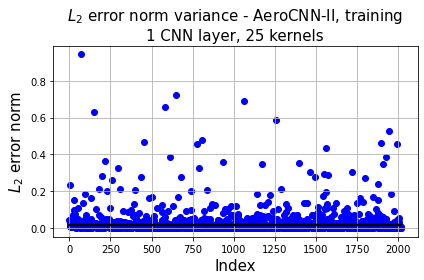

In [93]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

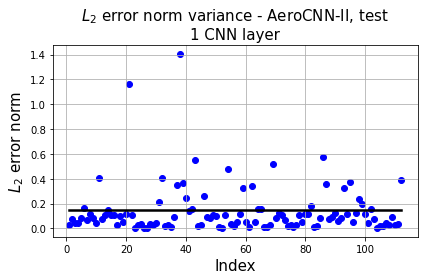

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n1 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

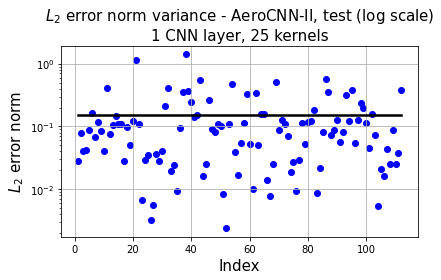

In [94]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

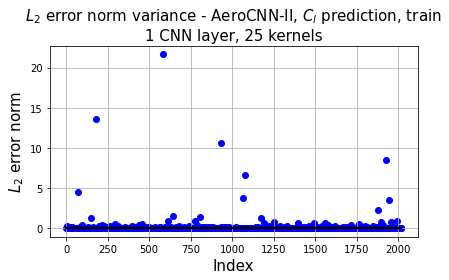

In [95]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

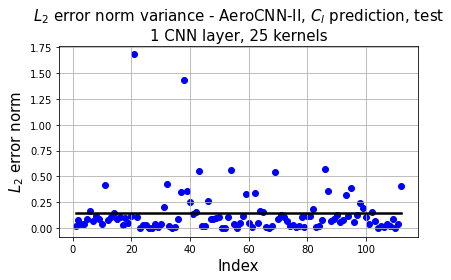

In [96]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

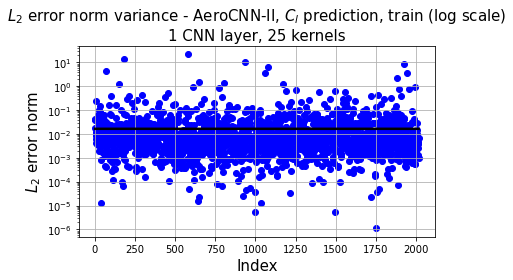

In [97]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

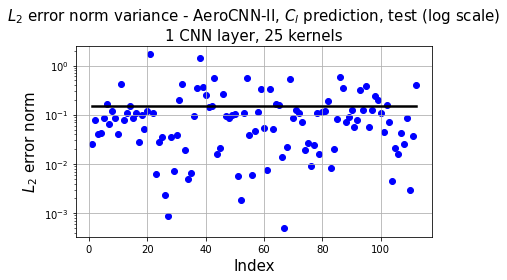

In [99]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

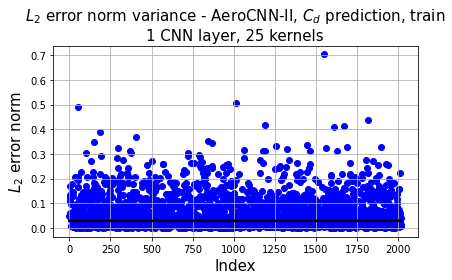

In [98]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

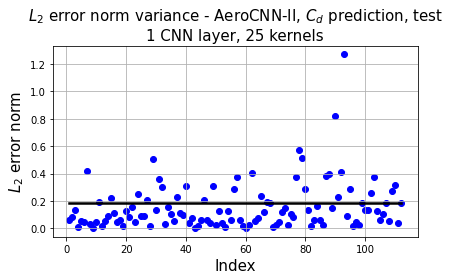

In [100]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

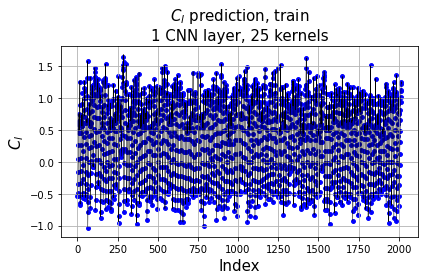

In [102]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

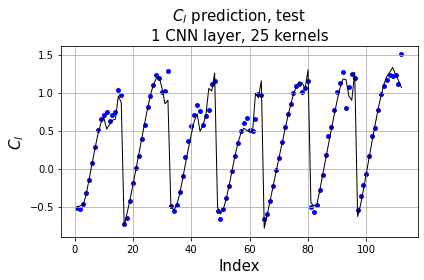

In [103]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

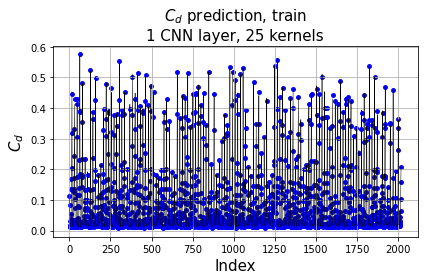

In [104]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

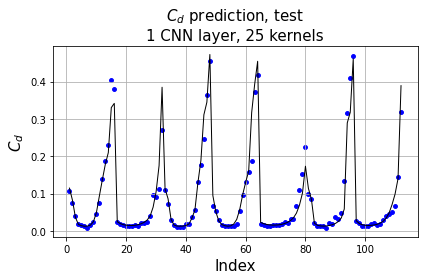

In [106]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

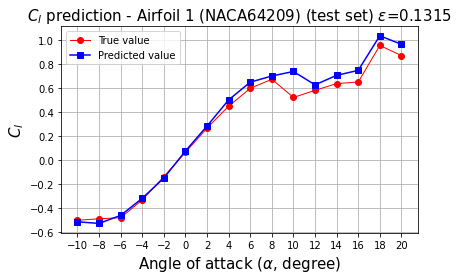

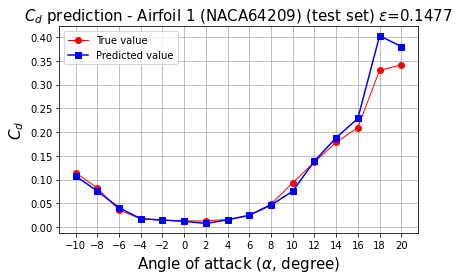

In [73]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

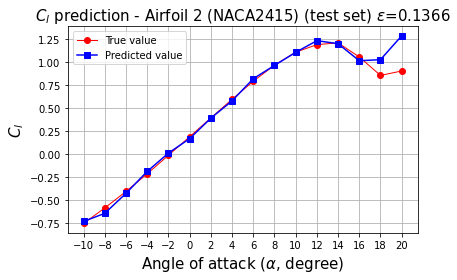

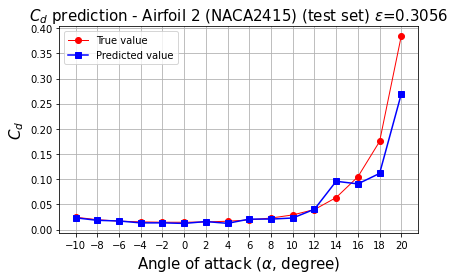

In [74]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

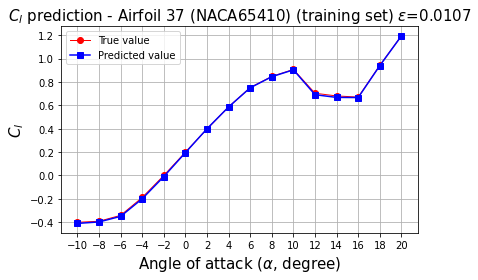

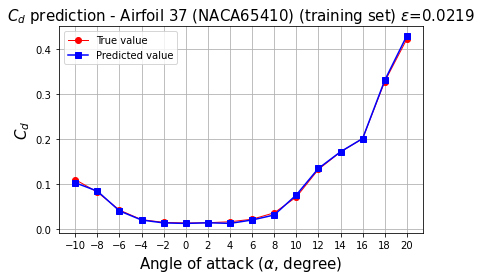

In [75]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

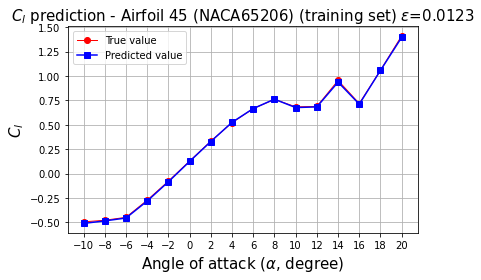

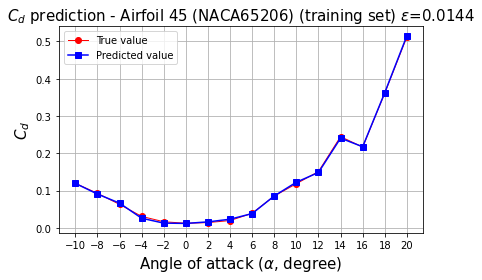

In [76]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

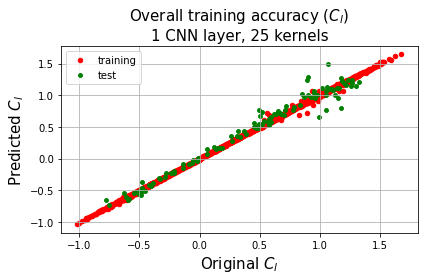

In [82]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 25 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

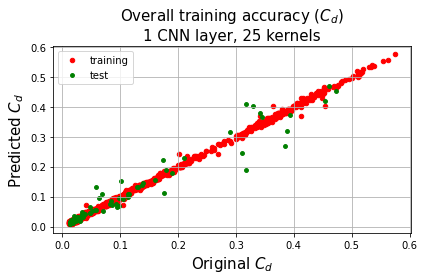

In [84]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 25 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

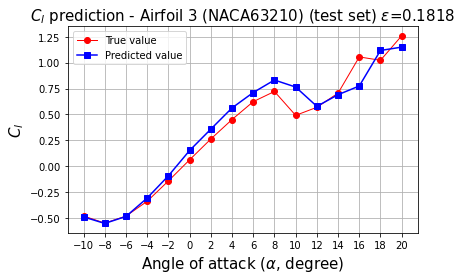

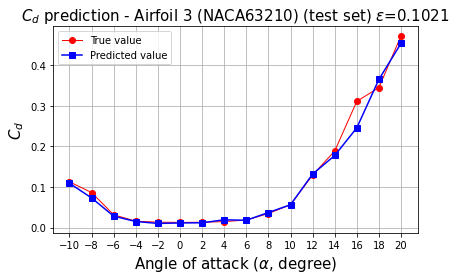

In [79]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [80]:
airfoiltest11_predict = decoded_test[16*9:16*10]

airfoiltest11_cl=y_test[16*9:16*10,0,:]
airfoiltest11_cd=y_test[16*9:16*10,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[9*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[9*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\cfdML\AppData\Local\Temp\ipykernel_29564\2581079272.py:6: RuntimeWarning: invalid value encountered in double_scalars
  epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
C:\Users\cfdML\AppData\Local\Temp\ipykernel_29564\2581079272.py:7: RuntimeWarning: invalid value encountered in double_scalars
  epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))


ValueError: cannot reshape array of size 0 into shape (16,)

In [85]:
from sklearn.metrics import r2_score

r2TrainCl=r2_score(y_train[:,0,:], decoded_train[:,0,:])
r2TrainCd=r2_score(y_train[:,1,:], decoded_train[:,1,:])
r2TestCl=r2_score(y_test[:,0,:], decoded_test[:,0,:])
r2TestCd=r2_score(y_test[:,1,:], decoded_test[:,1,:])

print(r2TrainCl)

print(r2TrainCd)

print(r2TestCl)

print(r2TestCd)

In [87]:
r2TrainCl=r2_score(y_train[:,0,:], decoded_train[:,0,:])
r2TrainCd=r2_score(y_train[:,1,:], decoded_train[:,1,:])
r2TestCl=r2_score(y_test[:,0,:], decoded_test[:,0,:])
r2TestCd=r2_score(y_test[:,1,:], decoded_test[:,1,:])

In [88]:
print(r2TrainCl)

0.9996204811939129


In [89]:
print(r2TrainCd)

0.9986545141501659


In [90]:
print(r2TestCl)

0.9687503346316473


In [91]:
print(r2TestCd)

0.9451833823577716
